In [1]:
from notebook_utils import setup
import pandas as pd
import networkx as nx
from collections import defaultdict

setup()

import matplotlib.style as style

style.use(["seaborn-white", "seaborn-paper"])

In [2]:
DATE = "16-dec"
DATA_DIR = "../data/{}/".format(DATE)
EXPORT_DIR = "../data/dataframes/{}/".format(DATE)

In [3]:
import pickle 
with open("./cached_graph.pickle", "rb") as f:
    cached_graph = pickle.load(f)

In [184]:
node_id_map = cached_graph["node_id_map"]
cached_graph.keys()

dict_keys(['all_user_clusters', 'graph', 'node_id_map', 'clustering_directed_unweighted', 'clustering_directed_weighted', 'clustering_undirected_unweighted'])

In [12]:
df_retweets = pd.read_pickle(EXPORT_DIR + './df_retweets.pickle')

In [23]:
known_users = set(df_users_by_follower_count.index.values)
retweet_users = set()
unknown_users = set()

def add_user(user_id):
    retweet_users.add(user_id)
    if (user_id not in known_users):
        unknown_users.add(user_id)

for i, user1, user2 in df_retweets[["user", "retweetedFrom_user"]].itertuples():
    add_user(user1)
    add_user(user2)

print("Known users", len(known_users))
print("Retweet users", len(retweet_users))
print("Unknown users", len(unknown_users))

Known users 1388621
Retweet users 1887736
Unknown users 1170397


In [24]:
print(len(known_users.union(unknown_users)))

2559018


In [5]:
df_users_by_follower_count = pd.read_pickle('./df_users_with_clustering.pickle').sort_values("followers_count", ascending=False)

In [6]:
df_users_by_follower_count["inactive"] = df_users_by_follower_count.apply(lambda user: (user.name) in all_inactive_users , axis=1)

In [7]:
inactive_users = df_users_by_follower_count[df_users_by_follower_count["inactive"] == True]

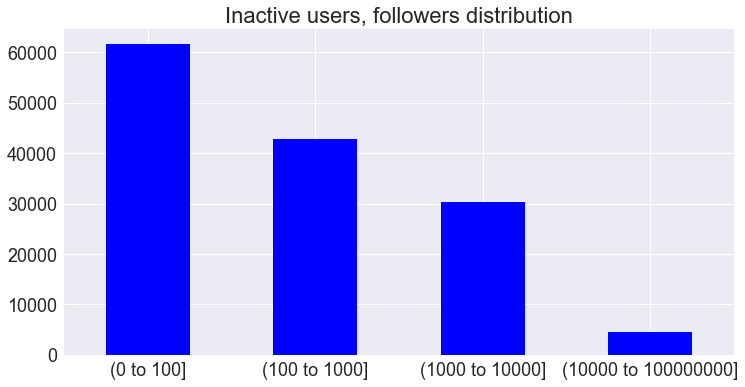

Total users 1,388,621
Total inactive users 147,751 (10.6%)
Followers distribution
max 87364085
min 0
mean 2184.247802045333
median 122.0


In [13]:
import matplotlib.pyplot as plt

style.use(["seaborn"])

cats, out = pd.cut(inactive_users.followers_count, bins=[0, 100, 1000, 10000, 100000000], retbins=True)

ax = cats.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(12,6))
ax.set_xticklabels([str(c).replace(","," to") for c in cats.cat.categories])
plt.title("Inactive users, followers distribution", fontdict={"fontsize":22})
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

total_count = df_users_by_follower_count.shape[0]
print("Total users {:,}".format(total_count))
print("Total inactive users {:,} ({:,.1f}%)".format(inactive_users.shape[0], (inactive_users.shape[0] / total_count) * 100))
print("Followers distribution")
print("max", inactive_users.followers_count.max())
print("min", inactive_users.followers_count.min())
print("mean", inactive_users.followers_count.mean())
print("median", inactive_users.followers_count.median())

In [9]:
import networkx as nx
filename = "../data/graphs/08-jan-sampled-graph-with-communities-smaller.gexf"
graph = nx.read_gexf(filename)

In [11]:
import networkx as nx
filename = "../data/graphs/08-jan-sampled-graph-with-inactive-smaller.gexf"
graph_inactive = nx.read_gexf(filename)

In [8]:
df_users = pd.read_pickle("./df_users_final.pickle")
suspended_uids = set(df_users[df_users["active_status"] == "suspended"].index)

In [12]:
inactive_count = 0
suspended_count = 0
for node, data in graph_inactive.nodes(data=True):
    if (data["is_inactive"]):
        inactive_count += 1
    if (data["user_id"] in suspended_uids):
        suspended_count += 1

In [18]:
print(inactive_count)

2933


In [15]:
def set_node_inactive(G):
    '''Add community to node attributes'''
    inactive_count = 0
    for n, data in list(G.nodes(data=True)):
        if ('user_id' in data):
            is_inactive = data["user_id"] in all_inactive_users
            data["is_inactive"] = is_inactive

            if is_inactive:
                inactive_count += 1
    print("Inactive {}/{}".format(inactive_count, len(G.nodes)))
    return G

graph_with_inactive = set_node_inactive(graph)

Inactive 3234/44474


In [4]:
filename = "../data/graphs/08-jan-sampled-graph-with-inactive-smaller.gexf"
nx.write_gexf(graph_with_inactive, filename)
print("Exported to {}".format(filename))

Exported to ../data/graphs/08-jan-sampled-graph-with-inactive-smaller.gexf
